In [128]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch

import sys
sys.path.insert(0, '../fem')
from heatconduction2d import main, postprocessdata, datasetgenerator
from randompolynomials import *

sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from VarMiON import VarMiON

In [130]:
simparams = {'inputdata': 'poly',
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

trainingdataparams = {'N_sensornodes': 144,
                      'N_outputnodes': 100,
                      'N_sims': 3}

params = {}
params['simparams'] = simparams
params['trainingdataparams'] = trainingdataparams

C = 0.2
c_theta = C*np.random.uniform(-1, 1, 10)
c_f = C*np.random.uniform(-1, 1, 10)
c_etab = C*np.random.uniform(-1, 1, 4)
c_etat = C*np.random.uniform(-1, 1, 4)
theta = randompoly2DO3sqr(c_theta)
f = randompoly2DO3sqr(c_f)
etab = randompoly1DO3(c_etab)
etat = randompoly1DO3(c_etat)
gl = 0
gr = 0

inputs = {'theta': theta,
          'f': f,
          'etab': etab,
          'etat': etat,
          'gl': gl,
          'gr': gr}

outputs = main(params, inputs, save=False, savedir='../../../trainingdata', label='test')

# generatedataset(params, save=True, savedir='../../../trainingdata', label='test')

optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-16


In [131]:
from VarMiON import VarMiON

model = VarMiON
logdir = '../../../nnlogs'
sublogdir = 'poly_nonzeroN'
map_location = 'cpu'
model = loadmodelfromlabel(model=VarMiON, label='allchanges_new', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

data_postprocessed = postprocessdata(params, inputs, outputs)
Theta = data_postprocessed['Theta']
F = data_postprocessed['F']
N = data_postprocessed['N']
x = data_postprocessed['x']
u = data_postprocessed['u']

/tmp/ipykernel_2686284/875792764.py:49: RuntimeWarning: divide by zero encountered in divide
  fig = ax.tripcolor(x[:,0], x[:,1], np.abs((u_hat - u)/u), norm=matplotlib.colors.LogNorm())
/tmp/ipykernel_2686284/875792764.py:60: RuntimeWarning: divide by zero encountered in divide
  APE = np.abs((u_hat - u)/u)


MAPE: 0.05750426784303955


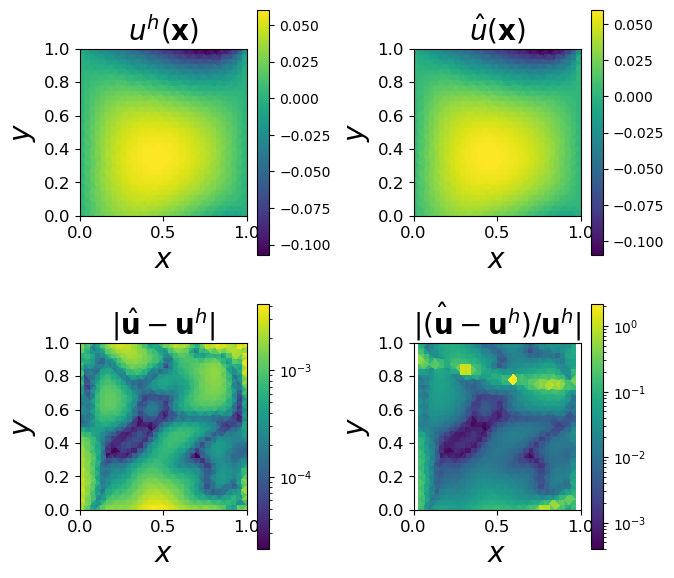

In [132]:
x = outputs['x']
u = outputs['u']
u_hat = model.simforward(Theta, F, N, x)

#plot
fig, axs = plt.subplots(2,2, figsize=(7, 7))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.2)
size_title = 20
size_ticklabels = 12
size_axeslabels = 20

ax = axs[0,0]
fig = ax.tripcolor(x[:,0], x[:,1], u)
ax.set_title(r"$u^h(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[0,1]
fig = ax.tripcolor(x[:,0], x[:,1], u_hat)
ax.set_title(r"$\hat{u}(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[1,0]
fig = ax.tripcolor(x[:,0], x[:,1], np.abs(u_hat - u), norm=matplotlib.colors.LogNorm())
ax.set_title(r"$|\hat{\mathbf{u}} - \mathbf{u}^h|$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[1,1]
fig = ax.tripcolor(x[:,0], x[:,1], np.abs((u_hat - u)/u), norm=matplotlib.colors.LogNorm())
ax.set_title(r"$|\hat{(\mathbf{u}} - \mathbf{u}^h)/\mathbf{u}^h|$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

APE = np.abs((u_hat - u)/u)
APE[APE==np.inf] = np.nan
MAPE = np.nanmean(APE)
print('MAPE: '+(str(MAPE)))
# plt.savefig("nonzeroN.pdf", bbox_inches='tight')

In [106]:
x = torch.linspace(0,1,100)
y = torch.zeros(100)
x = torch.vstack([x,y]).T
phi = model.Trunk(x[:None,None,:]).squeeze()

In [107]:
D = model.NLBranch.forward(torch.ones((1,12,12), dtype=model.dtype)).squeeze()

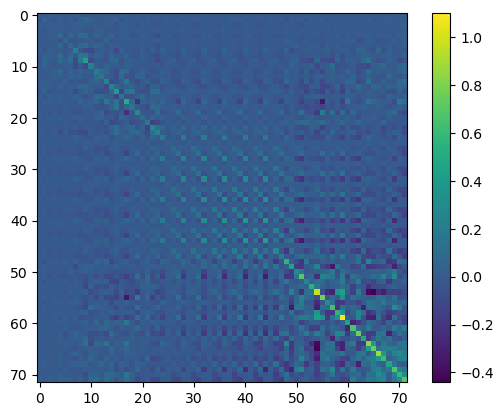

In [108]:
plt.imshow(D.detach().numpy())
plt.colorbar()

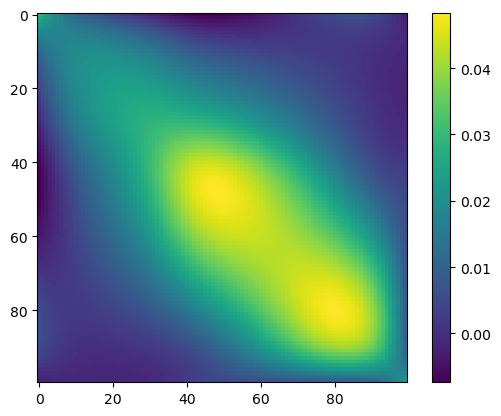

In [109]:
G = torch.einsum('mi,ij,nj->mn', phi, D, phi).detach().numpy()
plt.imshow(G)
plt.colorbar()

### Test score

In [114]:
#Test dataset
N_samples = 10000
Theta_test = torch.tensor(np.load('../../../trainingdata/polynomial/nonzeroN/positivef_test/Theta.npy'))[:N_samples]
F_test = torch.tensor(np.load('../../../trainingdata/polynomial/nonzeroN/positivef_test/F.npy'))[:N_samples]
N_test = torch.tensor(np.load('../../../trainingdata/polynomial/nonzeroN/positivef_test/N.npy'))[:N_samples]
x_test = torch.tensor(np.load('../../../trainingdata/polynomial/nonzeroN/positivef_test/x.npy'))[:N_samples]
u_test = torch.tensor(np.load('../../../trainingdata/polynomial/nonzeroN/positivef_test/u.npy'))[:N_samples]

In [115]:
from VarMiON import VarMiON

model = VarMiON
logdir = '../../../nnlogs'
sublogdir = 'poly_nonzeroN'
map_location = 'cpu'

noLBbias = loadmodelfromlabel(model=VarMiON, label='noLBbias', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
noNLBoutputReLU = loadmodelfromlabel(model=VarMiON, label='noNLBoutputReLU', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
PosDefSymD = loadmodelfromlabel(model=VarMiON, label='PosDefSymD_tril', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
PosDefSymD_noNLBoutputReLU = loadmodelfromlabel(model=VarMiON, label='PosDefSymD_noNLBoutputReLU_tril', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
scale_invariance = loadmodelfromlabel(model=VarMiON, label='scale_invariance', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
norm_basis = loadmodelfromlabel(model=VarMiON, label='norm_basis', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
allchanges = loadmodelfromlabel(model=VarMiON, label='allchanges_new', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
VarMiON = loadmodelfromlabel(model=VarMiON, label='VarMiON', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeldict = {'VarMiON': VarMiON,
             'No bias': noLBbias,
             'No output ReLU': noNLBoutputReLU,
             'SymPosDefD': PosDefSymD,
             'SymPosDefD, no output ReLU': PosDefSymD_noNLBoutputReLU,
             'Scale invariant': scale_invariance,
             'Normalized basis': norm_basis,
             'allchanges': allchanges}

/tmp/ipykernel_2686284/762588302.py:13: RuntimeWarning: divide by zero encountered in divide
  APE = np.abs((u_hat - u_test.detach().numpy())/u_test.detach().numpy())


Text(0.5, 0, '$|(\\hat{u} - u^h)/u^h|$')

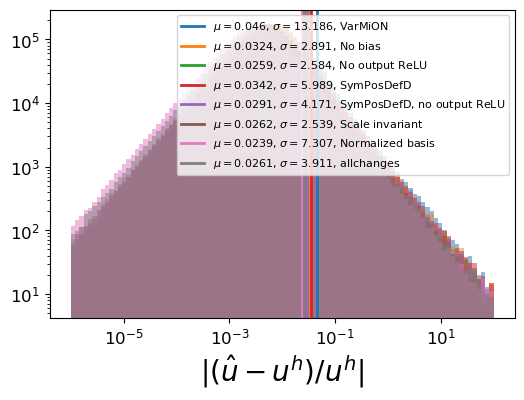

In [116]:
size_title = 20
size_ticklabels = 12
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

i=0
for model in modeldict:
    u_hat = modeldict[str(model)].forward(Theta_test, F_test, N_test, x_test).detach().numpy()
    APE = np.abs((u_hat - u_test.detach().numpy())/u_test.detach().numpy())
    APE = APE[APE!=np.inf]
    MAPE = np.average(APE)
    sigma = np.std(APE)
    # ax.hist(100*APE, bins=np.linspace(0,10,100), density=True, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
    ax.hist(APE, bins=np.logspace(-6,2,100), density=False, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
    ax.axvline(MAPE,0,1, linewidth=2, color=colors[i], label=r'$\mu=$'+str(np.around(MAPE, 4))+r', $\sigma=$'+str(np.around(sigma, 3))+', '+str(model))
    # ax.axvline(100*MAPE,0,1, linewidth=2, color=colors[i], label=str(np.around(100*MAPE, 2))+'% $\pm$'+str(np.around(sigma, 2))+'%, '+str(model))
    i+=1
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=8)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$|(\hat{u} - u^h)/u^h|$', fontsize=size_axeslabels)
# ax.set_xlabel(r'Val. error in %', fontsize=size_axeslabels)
# ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
# ax.grid()

# plt.savefig("changes.svg", bbox_inches='tight')

/tmp/ipykernel_2686284/333198960.py:13: RuntimeWarning: divide by zero encountered in divide
  APE = np.abs((u_hat - u_test.detach().numpy())/u_test.detach().numpy())


Text(0, 0.5, 'Density')

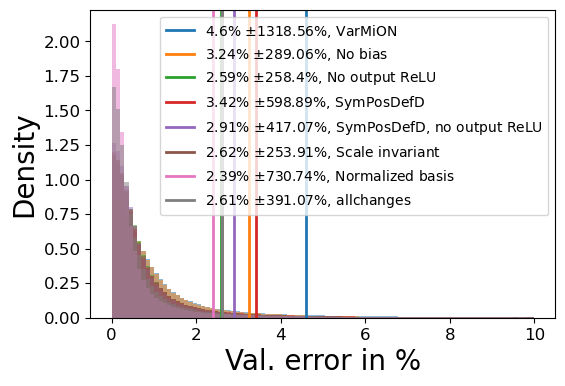

In [117]:
size_title = 20
size_ticklabels = 12
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

i=0
for model in modeldict:
    u_hat = modeldict[str(model)].forward(Theta_test, F_test, N_test, x_test).detach().numpy()
    APE = np.abs((u_hat - u_test.detach().numpy())/u_test.detach().numpy())
    APE = APE[APE!=np.inf]
    APE_pct = 100*APE
    MAPE = np.average(APE_pct)
    sigma = np.std(APE_pct)
    ax.hist(APE_pct, bins=np.linspace(0,10,100), density=True, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
    # ax.hist(APE, bins=np.logspace(-9,2,100), density=False, alpha=0.5, linewidth=1, color=colors[i], histtype='step')
    # ax.axvline(MAPE,0,1, linewidth=2, color=colors[i], label=r'$\mu=$'+str(np.around(MAPE, 4))+r', $\sigma=$'+str(np.around(sigma, 4))+', '+str(model))
    ax.axvline(MAPE,0,1, linewidth=2, color=colors[i], label=str(np.around(MAPE, 2))+'% $\pm$'+str(np.around(sigma, 2))+'%, '+str(model))
    i+=1
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=10)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$|(\hat{u} - u^h)/u^h|$', fontsize=size_axeslabels)
ax.set_xlabel(r'Val. error in %', fontsize=size_axeslabels)
ax.set_ylabel(r'Density', fontsize=size_axeslabels)
# ax.grid()

# plt.savefig("allchanges.svg", bbox_inches='tight')

### Positive definiteness

In [145]:
from VarMiON import VarMiON

model = VarMiON
logdir = '../../../nnlogs'
sublogdir = 'poly_nonzeroN'
map_location = 'cpu'
PosDefSymD = loadmodelfromlabel(model=VarMiON, label='PosDefSymD_tril', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
PosDefSymD_noNLBoutputReLU = loadmodelfromlabel(model=VarMiON, label='PosDefSymD_noNLBoutputReLU_tril', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
VarMiON = loadmodelfromlabel(model=VarMiON, label='VarMiON', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeldict = {'VarMiON': VarMiON,
    'SymPosDefD': PosDefSymD,
            'SymPosDefD, no output ReLU': PosDefSymD_noNLBoutputReLU}

In [146]:
# Theta_test = torch.rand((100,12,12),dtype=torch.double)
# D = model.NLBranch.forward(Theta_test)
# v = torch.normal(0,1,(100,1))
# # v = torch.zeros((100,1))
# pd = torch.einsum('ni,nij,nj->n',v,D,v).detach().numpy()

Text(0, 0.5, 'Counts')

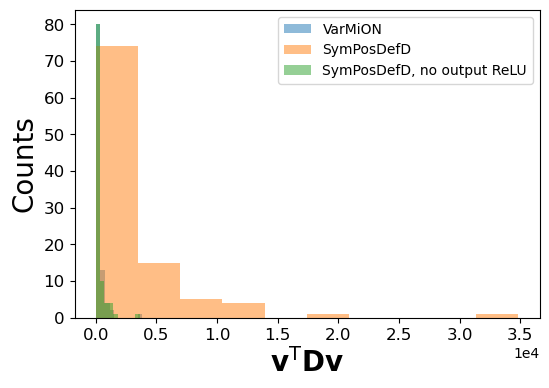

In [147]:
Theta_test = torch.normal(0,1,(100,12,12),dtype=torch.double)
v = torch.normal(0,1,(100,1))
# v = torch.zeros((100,1))
size_title = 20
size_ticklabels = 12
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

i=0
for model in modeldict:
    D = modeldict[str(model)].NLBranch.forward(Theta_test)
    pd = torch.einsum('ni,nij,nj->n',v,D,v).detach().numpy()
    ax.hist(pd, label=str(model), alpha=0.5)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=10)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$\mathbf{v}^{\mathrm{T}}\mathbf{D}\mathbf{v}$', fontsize=size_axeslabels)
# ax.set_xlabel(r'Val. error in %', fontsize=size_axeslabels)
ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
# ax.grid()

# plt.savefig("positivedefiniteness.svg", bbox_inches='tight')

### Scale invariance

In [251]:
labda = torch.rand(100,1,1, dtype=torch.double)

Theta_test = torch.rand((100,12,12),dtype=torch.double)
v = torch.normal(0,1,(100,1))
# v = torch.zeros((100,1))
size_title = 20
size_ticklabels = 12
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

i=0
for model in modeldict:
    D = modeldict[str(model)].NLBranch.forward(Theta_test)
    print(modeldict[str(model)].params['hparams']['Cholesky'])
    pd = torch.einsum('ni,nij,nj->n',v,D,v).detach().numpy()
    ax.hist(pd, label=str(model), alpha=0.5)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=10)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$\mathbf{v}^{\mathrm{T}}\mathbf{D}\mathbf{v}$', fontsize=size_axeslabels)
# ax.set_xlabel(r'Val. error in %', fontsize=size_axeslabels)
# ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
# ax.grid()

# plt.savefig("positivedefiniteness.pdf", bbox_inches='tight')